In [1]:
# %load_ext autoreload
# %autoreload 2

### Authors:
- [Karan Bhagat](mailto:kb.in.triangulum@gmail.com) - Developer
- [Christine Task](mailto:christine.task@knexusresearch.com) - Project technical lead
- [Dhruv Kapur](mailto:dhruvka@umich.edu) - Contributor

## NIST Collaborative Research Cycle (CRC)
### Example Notebook 4: Privacy Utility Tradeoff (Relationship between percent unique exact matches and k-marginal score).

In this notebook we use the data and metrics archive to empirically explore the classic concept of the "privacy/utility tradeoff curve". Does each step of improved utility (by k-marginal score) relate to an equal step in reduced privacy (by the unique exact match score)? For full definitions of these metrics, see the report.html files in the data-and-metrics-bundle. This notebook programmatically collects the k-marginal and UEM scores from the report.json files for every submission in the archive. 

Which techniques below seem to be winning the privacy/utility trade-off? Which have significant problems with privacy, with utility or with both? Don't forget that you can use the index data frame to identify specific algorithms of interest for further exploration (see intro notebook for an example).

#### List of topics covered in this notebook:  
0. [Setup notebook.](#nb4-section-0)   
1. [Load deid datasets index file (index.csv).](#nb4-section-1)    
2. [Get percentage of unique exact matches for each deid dataset.](#nb4-section-2)  
3. [Get k-marginal score for every deid dataset.](#nb4-section-3)   
4. [Show relationship between percent unique exact matches and k-marginal score.](#nb4-section-4)    

<a id="nb4-section-0"></a>
## Setup notebook.

### Import required libraries

In [2]:
# import required libraries
from pathlib import Path  # for creating paths for the filesystem operations
import os  # for filesystem operations
import pandas as pd  # for tabular data operations
import numpy as np  # for tabular data operations
import matplotlib.pyplot as plt  # for plotting data as charts
import json

### Import local libraries present in libs package

In [3]:
# Import helper constants and functions
# libs.util has some small utility functions
# such has read_json, list_report etc.
import libs.util as u
# libs.plot module contains some helper
# funtions to create matplotlib charts
import libs.plot as plot
# libs.strs contains some constant strings
# represeting columns/feature names in index.csv file,
# report.json file, etc.
# Some examples of such constants: 
# LIBRARY_NAME, ALOGIRTHM_NAME, TARGET_DATASETetc.
from libs.strs import *
# lib.strs provides get_colors function that can be
# use to generate N random colors.
import libs.color as color

### Change Current Working Directory (CWD) to: crc_data_and_metric_bundle

In [4]:
print('CWD Before: ', Path.cwd())
# get current working directory
cwd = Path.cwd()
# get path to the directory where is notebook is located
notebook_dir = u.notebook_path()
# Name of the parent directory of this notebook is crc_data_and_metric_bundle_1.0
new_cwd = notebook_dir.parent
# Set new current working directory path which ends in crc_data_and_metric_bundle_1.0
os.chdir(new_cwd)
print('CWD After: ', Path.cwd())

CWD Before:  /Users/karan/Documents/Knexus/NIST/SDNist/crc_acceleration_bundle_1.1/crc_data_and_metric_bundle_1.1/notebooks
CWD After:  /Users/karan/Documents/Knexus/NIST/SDNist/crc_acceleration_bundle_1.1/crc_data_and_metric_bundle_1.1


<a id="nb4-section-1"></a>  
## 1. Load deid datasets index file (index.csv)
index.csv file has tabular information about the deidentified (deid) datasets created using different data-deidentification libraries and algorithms. 
#### Location of index.csv: *crc_data_and_metric_bundle_1.0/index.csv*
#### Location of this notebook: *crc_data_and_metric_bundle_1.0/notebooks/intro.ipynb*

In [5]:
CWD = Path.cwd()  # get current working directory path
# Create path to the index.csv file
INDEX_FILE_PATH = Path(CWD, 'index.csv')
# read index csv into idx_df variable
# idx stands for index
idx_df = pd.read_csv(INDEX_FILE_PATH, index_col=0).reset_index(drop=True)

Index data has a total of 298 different deid. datasets and each dataset has 23 different properties.

In [6]:
# See the shape of the index dataframe.
idx_df.shape

(324, 22)

In [7]:
# See five random rows of the index dataframe
idx_df.sample(5)

,library name,algorithm name,algorithm type,target dataset,feature set name,feature space size,features list,privacy category,privacy label detail,epsilon,...,variant label detail,research papers,data path,labels path,report path,team,submission number,submission timestamp,quasi identifiers subset,deid data id
114,sdv,tvae,neural net,national2019,industry-focused,108108000,"PUMA, SEX, MSP, HISP, RAC1P, OWN_RENT, INDP_CA...",non_dp,The TVAE Synthesizer uses a variational autoen...,NaN,...,NaN,https://doi.org/10.48550/arXiv.1907.00503,deid_data/sdv_tvae/national/tvae_industry_1.csv,deid_data/sdv_tvae/national/tvae_industry_1.json,deid_data/sdv_tvae/national/report_tvae_indust...,CRC,NaN,5/20/2023 00:00:00,NaN,90a69ce2377ae57864b5971e1cab1d885c6a41e8
220,subsample_40pcnt,subsample_40pcnt,sdc,ma2019,demographic-focused,227026800,"AGEP, SEX, MSP, RAC1P, HOUSING_TYPE, OWN_RENT,...",sdc,A simple uniform random 40% subsample of the t...,NaN,...,NaN,https://www.census.gov/content/dam/Census/libr...,deid_data/subsample_40pcnt/ma/subsample_40pcnt...,deid_data/subsample_40pcnt/ma/subsample_40pcnt...,deid_data/subsample_40pcnt/ma/report_subsample...,CRC,NaN,5/20/2023 00:00:00,NaN,08b95430a7a380eb6325932a0a3ab6174a93e36c
284,synthcity,pategan,neural net,tx2019,demographic-focused,227026800,"AGEP, SEX, MSP, RAC1P, HOUSING_TYPE, OWN_RENT,...",dp,The method uses the Private Aggregation of Tea...,1.0,...,added a column target to the original dataset ...,https://openreview.net/forum?id=S1zk9iRqF7,deid_data/synthcity_pategan/tx/pategan_n_iter_...,deid_data/synthcity_pategan/tx/pategan_n_iter_...,deid_data/synthcity_pategan/tx/report_pategan_...,CRC,NaN,5/20/2023 00:00:00,NaN,a50e92511602a3931c331cca7f61c13d28ad0448
50,rsynthpop,ipf,query matching,national2019,demographic-focused,227026800,"AGEP, SEX, MSP, RAC1P, HOUSING_TYPE, OWN_RENT,...",dp,differential privacy,2.0,...,NaN,https://doi.org/10.48550/arXiv.2206.01362,deid_data/rsynthpop_ipf_Rsynthpop-categorical/...,deid_data/rsynthpop_ipf_Rsynthpop-categorical/...,deid_data/rsynthpop_ipf_Rsynthpop-categorical/...,Rsynthpop-categorical,2.0,5/8/2023 11:31:23,NaN,016f41caf598e5bd01e051d0581651801f29f23a
154,smartnoise-synth,mst,stat model,tx2019,simple-features,14711336640000000000,"PUMA, AGEP, SEX, MSP, HISP, RAC1P, NOC, NPF, H...",dp,Differentially private synthetic data. From M...,10.0,...,NaN,https://doi.org/10.48550/arXiv.2108.04978,deid_data/smartnoise_mst/tx/mst_e_10_simple_tx...,deid_data/smartnoise_mst/tx/mst_e_10_simple_tx...,deid_data/smartnoise_mst/tx/report_mst_e_10_si...,CRC,NaN,5/20/2023 00:00:00,NaN,43580c159faf094b7535c561d24636bb72286d5d


### 1.1 Veiw available features in the index dataframe.
List features(columns) of each deid. dataset (each row) in the index dataframe (created from index.csv). 

Some features inform about the method of data synthesis (features such as 'library', 'algorithm name', 'epsilon', 'variant label' etc.) and others about the location of resources (such as 'data path' path to deid dataset csv file, 
'report path' path to sdnist evaluation report of the deid dataset file etc.)

In [8]:
# Iterate over the columns of index dataframe
# and print each column name
for col in idx_df.columns:
    print(col)

library name
algorithm name
algorithm type
target dataset
feature set name
feature space size
features list
privacy category
privacy label detail
epsilon
delta
variant label
variant label detail
research papers
data path
labels path
report path
team
submission number
submission timestamp
quasi identifiers subset
deid data id


In [9]:
# Use index_feature_description function from the libs.util module.
# index_feature_description function takes just one argument which 
# should be one of the column name available in the index file. 
# Column names are printed in the last code cell for your reference.
u.index_feature_description(LIBRARY_NAME)


Index Column: 
-------------
library name


Description:
-----------
Software library used for this submission, or team name if a private codebase was used


<a id="nb4-section-2"></a>
## 2. Get percentage of unique exact matches for each deid dataset.

In [10]:
# Show available evaluation results for unique exact matches metric
# in a report.json file
# We grab the 'percent records matched in target data'
# from this metric
u.list_report(idx_df, UNIQUE_EXACT_MATCHES)

 unique_exact_matches
--- records matched in target data
--- percent records matched in target data
--- unique target records
--- percent unique target records


In [11]:
PERCENT_UNIQUE_EXACT_MATCHES = 'percent_unique_exact_matches'

# Create a new zero filled column
idx_df[PERCENT_UNIQUE_EXACT_MATCHES] = np.zeros(idx_df.shape[0]).astype(int)

# Iterate over each row (deid dataset) in index dataframe.
for i, row in idx_df.iterrows():
    # Get path of the SDNIST evaluation report directory
    # for the deid dataset in current row.
    report_dir_path = row[REPORT_PATH]  # report directory path
    # Create path to the report.json file in the report directory.
    report_json_path = Path(report_dir_path, 'report.json')
    # Read the json file at report_json_path into a 
    # python dictionary variable report_dict.
    with open(report_json_path) as f:
        report_dict = json.load(f)
        
    # Get percentage of records in deid data 
    # that exactly matches the unique records in target data
    percent_unique_matches = report_dict[UNIQUE_EXACT_MATCHES][PERCENT_RECORDS_MATCHED_IN_TARGET_DATA]

    # Save percentage of unique exact matches in index dataframe
    idx_df.loc[i, PERCENT_UNIQUE_EXACT_MATCHES] = percent_unique_matches
    
# See 10 random sample records:
# the new column percent_unique_exact_matches which we added to 
# the index dataframe just now.
columns_to_show = [LIBRARY_NAME, ALGORITHM_NAME, ALGORITHM_TYPE, 
                   PRIVACY_CATEGORY, PERCENT_UNIQUE_EXACT_MATCHES]
idx_df[columns_to_show].sample(10)

,library name,algorithm name,algorithm type,privacy category,percent_unique_exact_matches
139,smartnoise-synth,mst,stat model,dp,9.68
273,synthcity,pategan,neural net,dp,0.00
303,synthcity,privbayes,stat model,dp,0.16
216,subsample_1pcnt,subsample_1pcnt,sdc,sdc,0.95
316,synthcity,tvae,neural net,non_dp,11.01
179,smartnoise-synth,pacsynth,query matching,dp,14.39
323,tumult,DPHist,histogram,dp,99.81
304,synthcity,privbayes,stat model,dp,0.37
155,smartnoise-synth,mwem,query matching,dp,0.30
234,subsample_5pcnt,subsample_5pcnt,sdc,sdc,4.99


<a id="nb4-section-3"></a>
## 3. Get k-marginal score for every deid dataset.

In [12]:
# Create a new zero filled column
idx_df[K_MARGINAL_SCORE] = np.zeros(idx_df.shape[0]).astype(int)

# Iterate over each row (deid dataset) in filtered index dataframe.
for i, row in idx_df.iterrows():
    # Get path of the SDNIST evaluation report directory
    # for the deid dataset in current row.
    report_dir_path = row[REPORT_PATH]  # report directory path
    # Create path to the report.json file in the report directory.
    report_json_path = Path(report_dir_path, 'report.json')
    # Read the json file at report_json_path into a 
    # python dictionary variable report_dict.
    with open(report_json_path) as f:
        report_dict = json.load(f)
    # Get the k-marginal score from the report dictionary. 
    k_marg_score = report_dict[K_MARGINAL][K_MARGINAL_SYNOPSYS][K_MARGINAL_SCORE]
    
    # Save k-marginal score of the deid dataset in current row
    idx_df.loc[i, K_MARGINAL_SCORE] = k_marg_score

# See the first five recrods and 
# the new column k-marginal score which we added to 
# the filtered index dataframe just now.
columns_to_show = [LIBRARY_NAME, ALGORITHM_NAME, ALGORITHM_TYPE, 
                   PRIVACY_CATEGORY, PERCENT_UNIQUE_EXACT_MATCHES, K_MARGINAL_SCORE]
idx_df[columns_to_show].sample(10)

,library name,algorithm name,algorithm type,privacy category,percent_unique_exact_matches,k_marginal_score
230,subsample_40pcnt,subsample_40pcnt,sdc,sdc,39.67,982
155,smartnoise-synth,mwem,query matching,dp,0.30,777
258,synthcity,bayesian_network,stat model,non_dp,39.20,709
20,MostlyAI SD,MostlyAI SD,neural net,non_dp,0.01,927
16,Genetic SD,Genetic SD,query matching,dp,0.02,773
268,synthcity,pategan,neural net,dp,0.50,710
8,Genetic SD,Genetic SD,query matching,dp,0.00,781
265,synthcity,pategan,neural net,dp,0.00,559
76,sdcmicro,pram,sdc,sdc,58.25,980
41,rsynthpop,cart,stat model,non_dp,22.97,941


<a id="nb4-section-4"></a>
## 4. Show relationship between percent unique exact matches and k-marginal score.

<a id="nb4-section-4.1"></a>
### 4.1 Show relationship for different algorithm types.

In [15]:
u.index_feature_description(ALGORITHM_TYPE)


Index Column: 
-------------
algorithm type


Description:
-----------
A label indicating the general category of approach as specified below

sdc = 'Statistical Disclosure Control anonymization techniques-- Does direct perturbation, anonymization, redaction or generalization on individual records of target data'

query matching = 'Query Matching based synthetic data techniques-- Initializes a default synthetic data distribution and iteratively updates it to mimic query results on target data, using optimization or constraint satisfaction approaches'

neural net = 'Neural Network based synthetic data techniques-- Includes both GAN and Transformer Networks / Autoencoders'

stat model = 'Statistical Model based synthetic data techniques-- Uses some approach, other than a neural network, to construct a model of the feature relationships in the target data and uses this model to generate new records.'

histogram = 'Histogram based generation techniques-- Transforms the target data into a 

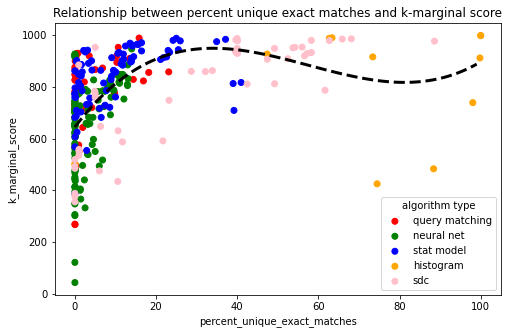

In [16]:
color_map = {
    'query matching': 'red',
    'neural net': 'green',
    'stat model': 'blue',
    'histogram': 'orange',
    'sdc': 'pink'
}
plot.scatter(data=idx_df,
             x=PERCENT_UNIQUE_EXACT_MATCHES,
             y=K_MARGINAL_SCORE,
             color_by=ALGORITHM_TYPE,
             color_map=color_map,
             fit_curve=True,
             title='Relationship between percent unique exact matches and k-marginal score')

<a id="nb4-section-4.1.1"></a>
#### 4.1.1 Show relationship for different algorithm types in only national2019 datasets.

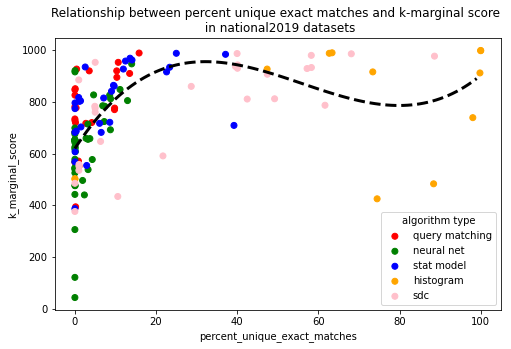

In [17]:
# Create mask to select deid datasets created from national2019 target dataset
mask = idx_df[TARGET_DATASET] == NATIONAL2019
na_idx_df = idx_df[mask]

# Plot relationship
plot.scatter(data=na_idx_df,
             x=PERCENT_UNIQUE_EXACT_MATCHES,
             y=K_MARGINAL_SCORE,
             color_by=ALGORITHM_TYPE,
             color_map=color_map,
             fit_curve=True,
             title='Relationship between percent unique exact matches and k-marginal score \n in national2019 datasets')

<a id="nb4-section-4.1.2"></a>
#### 4.1.2 Show relationship for different algorithm types in only ma2019 datasets.

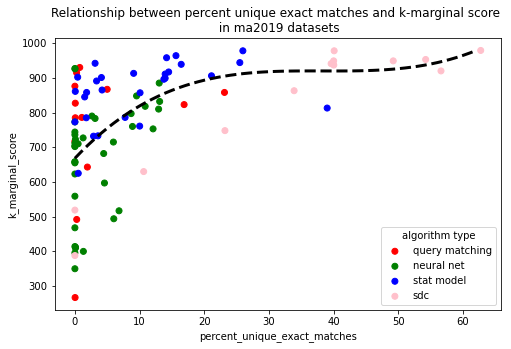

In [18]:
# Create mask to select deid datasets created from ma2019 target dataset
mask = idx_df[TARGET_DATASET] == MA2019
ma_idx_df = idx_df[mask]

# Plot relationship
plot.scatter(data=ma_idx_df,
             x=PERCENT_UNIQUE_EXACT_MATCHES,
             y=K_MARGINAL_SCORE,
             color_by=ALGORITHM_TYPE,
             color_map=color_map,
             fit_curve=True,
             title='Relationship between percent unique exact matches and k-marginal score \n in ma2019 datasets')

<a id="nb4-section-4.1.3"></a>
#### 4.1.3 Show relationship for different algorithm types in only tx2019 datasets.

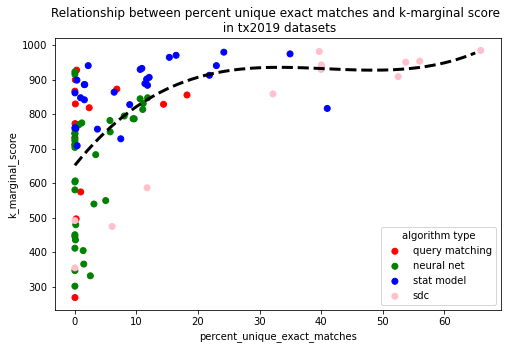

In [19]:
# Create mask to select deid datasets created from tx2019 target dataset
mask = idx_df[TARGET_DATASET] == TX2019
tx_idx_df = idx_df[mask]

# Plot relationship
plot.scatter(data=tx_idx_df,
             x=PERCENT_UNIQUE_EXACT_MATCHES,
             y=K_MARGINAL_SCORE,
             color_by=ALGORITHM_TYPE,
             color_map=color_map,
             fit_curve=True,
             title='Relationship between percent unique exact matches and k-marginal score \n in tx2019 datasets')

<a id="nb4-section-4.2"></a>
### 4.2 Show relationship for different privacy categories.

In [20]:
u.index_feature_description(PRIVACY_CATEGORY)


Index Column: 
-------------
privacy category


Description:
-----------
A code indicating the general category of privacy protection as specified below

sdc = 'Statistical Disclosure Control'

dp = 'Differential Privacy'

non_dp = 'Synthetic Data (Non-differentially Private)'


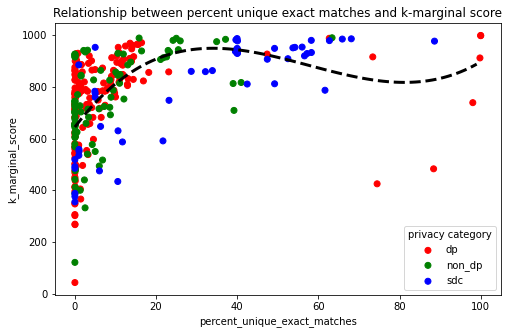

In [21]:
color_map = {
    'dp': 'red',
    'non_dp': 'green',
    'sdc': 'blue'
}
plot.scatter(data=idx_df,
             x=PERCENT_UNIQUE_EXACT_MATCHES,
             y=K_MARGINAL_SCORE,
             color_by=PRIVACY_CATEGORY,
             color_map=color_map,
             fit_curve=True,
             title='Relationship between percent unique exact matches and k-marginal score')

<a id="nb4-section-4.2.1"></a>
#### 4.2.1 Show relationship for different privacy categories in only national2019 datasets.

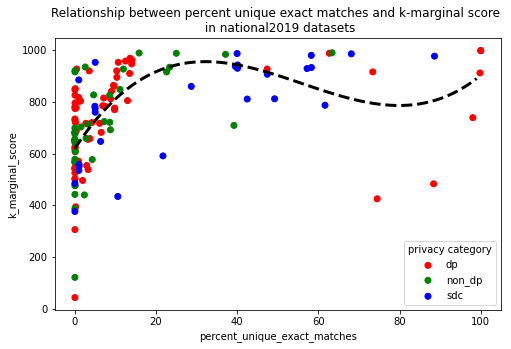

In [22]:
# Create mask to select deid datasets created from national2019 target dataset
mask = idx_df[TARGET_DATASET] == NATIONAL2019
na_idx_df = idx_df[mask]

# Plot relationship
plot.scatter(data=na_idx_df,
             x=PERCENT_UNIQUE_EXACT_MATCHES,
             y=K_MARGINAL_SCORE,
             color_by=PRIVACY_CATEGORY,
             color_map=color_map,
             fit_curve=True,
             title='Relationship between percent unique exact matches and k-marginal score \n in national2019 datasets')

<a id="nb4-section-4.2.2"></a>
#### 4.2.2 Show relationship for different privacy categories in only ma2019 datasets.

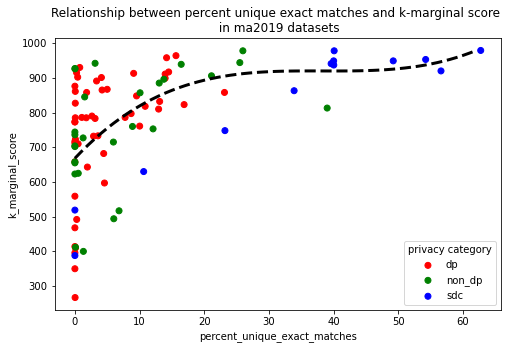

In [23]:
# Create mask to select deid datasets created from ma2019 target dataset
mask = idx_df[TARGET_DATASET] == MA2019
ma_idx_df = idx_df[mask]

# Plot relationship
plot.scatter(data=ma_idx_df,
             x=PERCENT_UNIQUE_EXACT_MATCHES,
             y=K_MARGINAL_SCORE,
             color_by=PRIVACY_CATEGORY,
             color_map=color_map,
             fit_curve=True,
             title='Relationship between percent unique exact matches and k-marginal score \n in ma2019 datasets')

<a id="nb4-section-4.2.3"></a>
#### 4.2.3 Show relationship for different privacy categories in only tx2019 datasets.

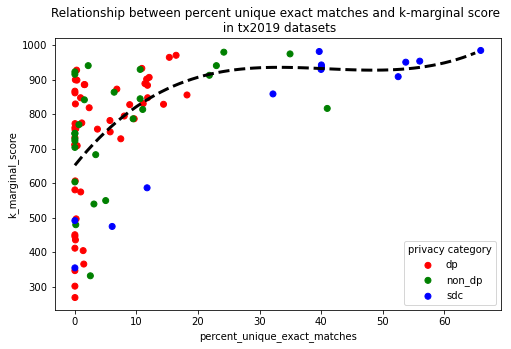

In [24]:
# Create mask to select deid datasets created from tx2019 target dataset
mask = idx_df[TARGET_DATASET] == TX2019
tx_idx_df = idx_df[mask]

# Plot relationship
plot.scatter(data=tx_idx_df,
             x=PERCENT_UNIQUE_EXACT_MATCHES,
             y=K_MARGINAL_SCORE,
             color_by=PRIVACY_CATEGORY,
             color_map=color_map,
             fit_curve=True,
             title='Relationship between percent unique exact matches and k-marginal score \n in tx2019 datasets')